<a href="https://colab.research.google.com/github/biniyam-mulugeta/test_co_2/blob/main/google_resnet_120_v_new_best_LR.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import tensorflow as tf
import numpy as np 
import keras
from keras.models import Model
from keras.layers import Flatten,concatenate,GlobalAveragePooling2D,DepthwiseConv2D,Add#,Dense,Dropout,Conv2D
from keras.applications import densenet,mobilenet, mobilenet_v2,efficientnet#densenetmobilenet_v2#,efficientnet,vgg16,densenet
from keras.applications import vgg19,resnet
#from keras_preprocessing import image
#from keras_preprocessing.image import ImageDataGenerator
#from keras.utils.all_utils import to_categorical
from sklearn import preprocessing
from skimage.filters import threshold_otsu
import cv2
from pathlib import Path
import os
import glob
import matplotlib.pyplot as plt
#import seaborn as sns
#import zipfile
%matplotlib inline

In [3]:
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import RandomForestClassifier,VotingClassifier,AdaBoostClassifier
from sklearn.model_selection import KFold,StratifiedKFold,cross_val_score,GridSearchCV,StratifiedShuffleSplit
from sklearn.metrics import classification_report,f1_score,accuracy_score,confusion_matrix,ConfusionMatrixDisplay
from skimage import io

In [4]:
from keras.layers import Flatten,concatenate,GlobalAveragePooling2D,Input,Dense,Dropout,Conv2D,Activation,MaxPooling2D,BatchNormalization
from keras.layers import MaxPool2D,AveragePooling2D

In [5]:
import pandas as pd

In [6]:
SIZE = 32
data_image = []
data_label = []
for dir_path in glob.glob("/content/drive/My Drive/coffee_dataset/*"):
    label = dir_path.split("\\")[-1]
    print(label)
    for img_path in glob.glob(os.path.join(dir_path,"*.jpg")):
        print(img_path)
        img = cv2.imread(img_path,cv2.IMREAD_COLOR)
        img = cv2.resize(img,(SIZE,SIZE))
        img = cv2.cvtColor(img,cv2.COLOR_RGB2BGR)
        
        img = cv2.GaussianBlur(img,(5,5),0)
  
        #img = otsu_segmentation(img)]

        data_image.append(img)
        data_label.append(label)
data_image = np.array(data_image)
data_label = np.array(data_label)

Streaming output truncated to the last 5000 lines.
/content/drive/My Drive/coffee_dataset/rust_cro/1424_1.jpg
/content/drive/My Drive/coffee_dataset/rust_cro/1424_2.jpg
/content/drive/My Drive/coffee_dataset/rust_cro/1425.jpg
/content/drive/My Drive/coffee_dataset/rust_cro/1425_1.jpg
/content/drive/My Drive/coffee_dataset/rust_cro/1425_2.jpg
/content/drive/My Drive/coffee_dataset/rust_cro/1427.jpg
/content/drive/My Drive/coffee_dataset/rust_cro/1427_1.jpg
/content/drive/My Drive/coffee_dataset/rust_cro/1429.jpg
/content/drive/My Drive/coffee_dataset/rust_cro/1430.jpg
/content/drive/My Drive/coffee_dataset/rust_cro/1430_1.jpg
/content/drive/My Drive/coffee_dataset/rust_cro/1431.jpg
/content/drive/My Drive/coffee_dataset/rust_cro/1431_1.jpg
/content/drive/My Drive/coffee_dataset/rust_cro/1434.jpg
/content/drive/My Drive/coffee_dataset/rust_cro/1434_1.jpg
/content/drive/My Drive/coffee_dataset/rust_cro/1436.jpg
/content/drive/My Drive/coffee_dataset/rust_cro/1436_1.jpg
/content/drive/My D

In [7]:
le = preprocessing.LabelEncoder()
le.fit(data_label)
train_labe_encoded = le.transform(data_label)

In [8]:
x_train,y_train = data_image,train_labe_encoded
x_train = x_train/255.0

In [9]:
from keras.utils.all_utils import to_categorical
y_train_one_hot = to_categorical(y_train)

### train test validate splite

In [10]:
from sklearn.model_selection import train_test_split

In [11]:
x_tr,x_te,y_tr,y_te = train_test_split(x_train,y_train_one_hot,test_size=0.20,shuffle=True,random_state=42,stratify=y_train_one_hot)

In [12]:

print(x_tr.shape,'----',y_tr.shape)
print(x_te.shape,'----',y_te.shape)

(4944, 32, 32, 3) ---- (4944, 7)
(1236, 32, 32, 3) ---- (1236, 7)


In [13]:
x_v,x_tes,y_v,y_tes = train_test_split(x_te,y_te,test_size=0.5,shuffle=True,random_state=42,stratify=y_te)

In [14]:
shape = (32,32,3)

### GoogleNet

In [15]:
def inception_module(x,filters_1x1,filters_3x3_reduce,filters_3x3,filters_5x5_reduce,filters_5x5,filters_pool_proj,name=None):
    
    conv_1x1 = Conv2D(filters_1x1, (1, 1), padding='same', activation='relu', kernel_initializer=kernel_init, bias_initializer=bias_init)(x)
    
    conv_3x3 = Conv2D(filters_3x3_reduce, (1, 1), padding='same', activation='relu', kernel_initializer=kernel_init, bias_initializer=bias_init)(x)
    conv_3x3 = Conv2D(filters_3x3, (3, 3), padding='same', activation='relu', kernel_initializer=kernel_init, bias_initializer=bias_init)(conv_3x3)

    conv_5x5 = Conv2D(filters_5x5_reduce, (1, 1), padding='same', activation='relu', kernel_initializer=kernel_init, bias_initializer=bias_init)(x)
    conv_5x5 = Conv2D(filters_5x5, (3, 3), padding='same', activation='relu', kernel_initializer=kernel_init, bias_initializer=bias_init)(conv_5x5)

    pool_proj = MaxPool2D((3, 3), strides=(1, 1), padding='same')(x)
    pool_proj = Conv2D(filters_pool_proj, (1, 1), padding='same', activation='relu', kernel_initializer=kernel_init, bias_initializer=bias_init)(pool_proj)

    output = concatenate([conv_1x1, conv_3x3, conv_5x5, pool_proj], axis=3, name=name)
    
    return output

In [16]:
kernel_init = keras.initializers.he_uniform()
bias_init = keras.initializers.Constant(value=0.2)

In [17]:
input_layer = Input(shape=shape)

x = Conv2D(64, (3, 3), padding='same', strides=(1, 1), activation='relu', name='conv_1_7x7/2', kernel_initializer=kernel_init, bias_initializer=bias_init)(input_layer)
x = MaxPool2D((2, 2), padding='same', strides=(1, 1), name='max_pool_1_3x3/2')(x)
x = Conv2D(64, (1, 1), padding='same', strides=(2, 2), activation='relu', name='conv_2a_3x3/1')(x)
x = Conv2D(128, (3, 3), padding='same', strides=(1, 1), activation='relu', name='conv_2b_3x3/1')(x)
x = MaxPool2D((2, 2), padding='same', strides=(2, 2), name='max_pool_2_3x3/2')(x)

x = inception_module(x,
                     filters_1x1=32,
                     filters_3x3_reduce=96,
                     filters_3x3=128,
                     filters_5x5_reduce=16,
                     filters_5x5=32,
                     filters_pool_proj=32,
                     name='inception_3a')

x = inception_module(x,
                     filters_1x1=64,
                     filters_3x3_reduce=128,
                     filters_3x3=192,
                     filters_5x5_reduce=32,
                     filters_5x5=96,
                     filters_pool_proj=64,
                     name='inception_3b')

x = GlobalAveragePooling2D(name='avg_pool_5_3x3/1')(x)

x = Dropout(0.4)(x)

x = Dense(6, activation='softmax', name='output')(x)
google_net = Model(input_layer,x, name='inception_v1')

### ResNet

In [18]:
from keras.layers import add
stride = 1
CHANNEL_AXIS = 3

def res_layer(x ,filters,pooling = False,dropout = 0.0):
    temp = x
    temp = Conv2D(filters,(3,3),strides = stride,padding = "same",kernel_initializer='he_uniform')(temp)
    temp = BatchNormalization(axis = CHANNEL_AXIS)(temp)
    temp = Activation("relu")(temp)
    temp = Conv2D(filters,(3,3),strides = stride,padding = "same",kernel_initializer='he_uniform')(temp)

    x = add([temp,Conv2D(filters,(3,3),strides = stride,padding = "same",kernel_initializer='he_uniform')(x)])
    if pooling:
        x = MaxPooling2D((2,2))(x)
    if dropout != 0.0:
        x = Dropout(dropout)(x)
    x = BatchNormalization(axis = CHANNEL_AXIS)(x)
    x = Activation("relu")(x)
    return x

In [19]:
inp = Input(shape = shape)
x = inp
x = Conv2D(16,(3,3),strides = stride,padding = "same")(x)
x = BatchNormalization(axis = CHANNEL_AXIS)(x)
x = Activation("relu")(x)
x = res_layer(x,32,dropout = 0.2)
x = res_layer(x,64,dropout = 0.3)
x = GlobalAveragePooling2D()(x)
x = Dropout(0.23)(x)
x = Dense(7,activation = "softmax")(x)

resnet_model = Model(inp,x,name = "Resnet")

### proposed model

In [20]:
out1 = google_net.get_layer(index = -3).output
out2 = resnet_model.get_layer(index= -3).output
out = concatenate([out1,out2])

out = Dense(64,activation='relu')(out)
out = Dropout(0.45)(out)
out = Dense(128,activation='relu')(out)
out = Dropout(0.50)(out)
#out = Dense(256,activation='relu')(out)
#out = Dropout(0.50)(out)


output = Dense(7,activation='softmax')(out)

In [26]:
e_model = Model(inputs = [google_net.input,resnet_model.input],outputs = output)

In [22]:
opt = tf.keras.optimizers.Adam(learning_rate=0.0001)
e_model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
history = e_model.fit([x_tr,x_tr],y_tr,epochs=120,validation_data=([x_v,x_v],y_v))

Epoch 1/120
155/155 [==============================] - 17s 26ms/step - loss: 1.5756 - accuracy: 0.3821 - val_loss: 1.0592 - val_accuracy: 0.6019
Epoch 2/120
155/155 [==============================] - 3s 18ms/step - loss: 1.0433 - accuracy: 0.5890 - val_loss: 0.7284 - val_accuracy: 0.6877
Epoch 3/120
155/155 [==============================] - 3s 18ms/step - loss: 0.8196 - accuracy: 0.6604 - val_loss: 0.6839 - val_accuracy: 0.6926
Epoch 4/120
155/155 [==============================] - 3s 18ms/step - loss: 0.7277 - accuracy: 0.6895 - val_loss: 0.5030 - val_accuracy: 0.7557
Epoch 5/120
155/155 [==============================] - 3s 18ms/step - loss: 0.6663 - accuracy: 0.7037 - val_loss: 0.4769 - val_accuracy: 0.7573
Epoch 6/120
155/155 [==============================] - 3s 19ms/step - loss: 0.6254 - accuracy: 0.7255 - val_loss: 0.4579 - val_accuracy: 0.7605
Epoch 7/120
155/155 [==============================] - 3s 19ms/step - loss: 0.5707 - accuracy: 0.7377 - val_loss: 0.4216 - val_accuracy

In [31]:
def reinitialize(model):
    for l in model.layers:
        if hasattr(l,"kernel_initializer"):
            l.kernel.assign(l.kernel_initializer(tf.shape(l.kernel)))
        if hasattr(l,"bias_initializer"):
            l.bias.assign(l.bias_initializer(tf.shape(l.bias)))
        if hasattr(l,"recurrent_initializer"):
            l.recurrent_kernel.assign(l.recurrent_initializer(tf.shape(l.recurrent_kernel)))
reinitialize(e_model)

In [32]:

opt = tf.keras.optimizers.Adam(learning_rate=0.01)
e_model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
history1 = e_model.fit([x_tr,x_tr],y_tr,epochs=120,validation_data=([x_v,x_v],y_v))

Epoch 1/120
155/155 [==============================] - 5s 23ms/step - loss: 1.6291 - accuracy: 0.3485 - val_loss: 43.2733 - val_accuracy: 0.2751
Epoch 2/120
155/155 [==============================] - 3s 18ms/step - loss: 0.8972 - accuracy: 0.6141 - val_loss: 19.8660 - val_accuracy: 0.5615
Epoch 3/120
155/155 [==============================] - 3s 18ms/step - loss: 0.7379 - accuracy: 0.6576 - val_loss: 8.4022 - val_accuracy: 0.5227
Epoch 4/120
155/155 [==============================] - 3s 18ms/step - loss: 0.7229 - accuracy: 0.6679 - val_loss: 45.7489 - val_accuracy: 0.3932
Epoch 5/120
155/155 [==============================] - 3s 18ms/step - loss: 0.6401 - accuracy: 0.6831 - val_loss: 1.7649 - val_accuracy: 0.6392
Epoch 6/120
155/155 [==============================] - 3s 18ms/step - loss: 0.5955 - accuracy: 0.7041 - val_loss: 0.9420 - val_accuracy: 0.6456
Epoch 7/120
155/155 [==============================] - 3s 18ms/step - loss: 0.6145 - accuracy: 0.6982 - val_loss: 0.8658 - val_accura

In [29]:
def reinitialize(model):
    for l in model.layers:
        if hasattr(l,"kernel_initializer"):
            l.kernel.assign(l.kernel_initializer(tf.shape(l.kernel)))
        if hasattr(l,"bias_initializer"):
            l.bias.assign(l.bias_initializer(tf.shape(l.bias)))
        if hasattr(l,"recurrent_initializer"):
            l.recurrent_kernel.assign(l.recurrent_initializer(tf.shape(l.recurrent_kernel)))
reinitialize(e_model)

In [30]:
opt = tf.keras.optimizers.Adam(learning_rate=0.001)
e_model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
history2 = e_model.fit([x_tr,x_tr],y_tr,epochs=120,validation_data=([x_v,x_v],y_v))

Epoch 1/120
155/155 [==============================] - 5s 21ms/step - loss: 1.3449 - accuracy: 0.4292 - val_loss: 0.6786 - val_accuracy: 0.6909
Epoch 2/120
155/155 [==============================] - 3s 19ms/step - loss: 0.7292 - accuracy: 0.6531 - val_loss: 0.6229 - val_accuracy: 0.6683
Epoch 3/120
155/155 [==============================] - 3s 18ms/step - loss: 0.5912 - accuracy: 0.6919 - val_loss: 0.5476 - val_accuracy: 0.6893
Epoch 4/120
155/155 [==============================] - 3s 19ms/step - loss: 0.5492 - accuracy: 0.7112 - val_loss: 0.5066 - val_accuracy: 0.7233
Epoch 5/120
155/155 [==============================] - 3s 18ms/step - loss: 0.5336 - accuracy: 0.7259 - val_loss: 0.4348 - val_accuracy: 0.7994
Epoch 6/120
155/155 [==============================] - 3s 18ms/step - loss: 0.4462 - accuracy: 0.7785 - val_loss: 27.0639 - val_accuracy: 0.6472
Epoch 7/120
155/155 [==============================] - 3s 19ms/step - loss: 0.4017 - accuracy: 0.7979 - val_loss: 0.3035 - val_accuracy

In [33]:
def reinitialize(model):
    for l in model.layers:
        if hasattr(l,"kernel_initializer"):
            l.kernel.assign(l.kernel_initializer(tf.shape(l.kernel)))
        if hasattr(l,"bias_initializer"):
            l.bias.assign(l.bias_initializer(tf.shape(l.bias)))
        if hasattr(l,"recurrent_initializer"):
            l.recurrent_kernel.assign(l.recurrent_initializer(tf.shape(l.recurrent_kernel)))
reinitialize(e_model)

In [34]:
opt = tf.keras.optimizers.Adam(learning_rate=0.00001)
e_model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
history3 = e_model.fit([x_tr,x_tr],y_tr,epochs=120,validation_data=([x_v,x_v],y_v))

Epoch 1/120
155/155 [==============================] - 5s 21ms/step - loss: 1.9616 - accuracy: 0.1750 - val_loss: 1.8801 - val_accuracy: 0.2152
Epoch 2/120
155/155 [==============================] - 3s 18ms/step - loss: 1.8491 - accuracy: 0.2439 - val_loss: 1.7922 - val_accuracy: 0.4320
Epoch 3/120
155/155 [==============================] - 3s 18ms/step - loss: 1.7736 - accuracy: 0.3131 - val_loss: 1.6892 - val_accuracy: 0.5275
Epoch 4/120
155/155 [==============================] - 3s 18ms/step - loss: 1.6859 - accuracy: 0.3576 - val_loss: 1.5463 - val_accuracy: 0.5858
Epoch 5/120
155/155 [==============================] - 3s 18ms/step - loss: 1.5840 - accuracy: 0.3916 - val_loss: 1.3946 - val_accuracy: 0.6019
Epoch 6/120
155/155 [==============================] - 3s 18ms/step - loss: 1.4766 - accuracy: 0.4363 - val_loss: 1.2388 - val_accuracy: 0.7087
Epoch 7/120
155/155 [==============================] - 3s 18ms/step - loss: 1.3721 - accuracy: 0.4723 - val_loss: 1.1061 - val_accuracy:

In [35]:
def reinitialize(model):
    for l in model.layers:
        if hasattr(l,"kernel_initializer"):
            l.kernel.assign(l.kernel_initializer(tf.shape(l.kernel)))
        if hasattr(l,"bias_initializer"):
            l.bias.assign(l.bias_initializer(tf.shape(l.bias)))
        if hasattr(l,"recurrent_initializer"):
            l.recurrent_kernel.assign(l.recurrent_initializer(tf.shape(l.recurrent_kernel)))
reinitialize(e_model)

In [36]:
opt = tf.keras.optimizers.Adam(learning_rate=0.1)
e_model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
history4 = e_model.fit([x_tr,x_tr],y_tr,epochs=120,validation_data=([x_v,x_v],y_v))

Epoch 1/120
155/155 [==============================] - 33s 28ms/step - loss: 95861.2891 - accuracy: 0.1533 - val_loss: 1.9481 - val_accuracy: 0.1731
Epoch 2/120
155/155 [==============================] - 4s 25ms/step - loss: 1.9486 - accuracy: 0.1663 - val_loss: 1.9451 - val_accuracy: 0.1731
Epoch 3/120
155/155 [==============================] - 4s 24ms/step - loss: 1.9509 - accuracy: 0.1612 - val_loss: 1.9455 - val_accuracy: 0.1586
Epoch 4/120
155/155 [==============================] - 3s 21ms/step - loss: 1.9499 - accuracy: 0.1626 - val_loss: 1.9526 - val_accuracy: 0.1731
Epoch 5/120
155/155 [==============================] - 3s 18ms/step - loss: 1.9503 - accuracy: 0.1634 - val_loss: 1.9518 - val_accuracy: 0.1586
Epoch 6/120
155/155 [==============================] - 4s 23ms/step - loss: 1.9496 - accuracy: 0.1594 - val_loss: 1.9512 - val_accuracy: 0.1586
Epoch 7/120
155/155 [==============================] - 4s 23ms/step - loss: 1.9511 - accuracy: 0.1602 - val_loss: 1.9455 - val_accu

### plot the result

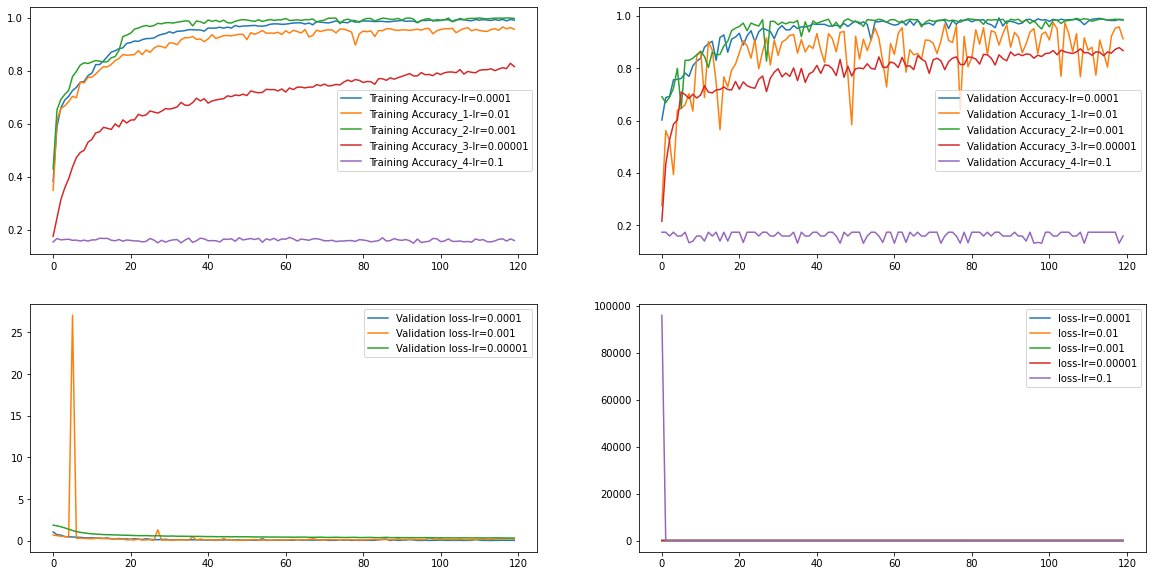

In [54]:
  acc = history.history['accuracy']
  val_acc = history.history['val_accuracy']
  loss = history.history['loss']
  val_loss = history.history['val_loss']
################
  acc1 = history1.history['accuracy']
  val_acc1 = history1.history['val_accuracy']
  loss1 = history1.history['loss']
  val_loss1 = history1.history['val_loss']
  #######
  acc2 = history2.history['accuracy']
  val_acc2 = history2.history['val_accuracy']
  loss2 = history2.history['loss']
  val_loss2 = history2.history['val_loss']
  ############
  acc3 = history3.history['accuracy']
  val_acc3 = history3.history['val_accuracy']
  loss3 = history3.history['loss']
  val_loss3 = history3.history['val_loss']
  ###########
  acc4 = history4.history['accuracy']
  val_acc4 = history4.history['val_accuracy']
  loss4 = history4.history['loss']
  val_loss4 = history4.history['val_loss']



  plt.figure(figsize=(20,15))
  epochs = range(len(acc))
  plt.subplot(321)
  plt.plot(epochs, acc, '', label = 'Training Accuracy-lr=0.0001')

  plt.plot(epochs, acc1, '', label = 'Training Accuracy_1-lr=0.01')

  plt.plot(epochs, acc2, '', label = 'Training Accuracy_2-lr=0.001')

  plt.plot(epochs, acc3, '', label = 'Training Accuracy_3-lr=0.00001')

  plt.plot(epochs, acc4, '', label = 'Training Accuracy_4-lr=0.1')

  #plt.title(f'Training and Validation accuray {i}')
  plt.legend(loc=0)
  #plt.figure(figsize=(10,10))
  plt.subplots_adjust(wspace=0.2,bottom=0.1)

  plt.subplot(322)
  plt.plot(epochs, val_acc, '', label= 'Validation Accuracy-lr=0.0001')

  plt.plot(epochs, val_acc1, '', label= 'Validation Accuracy_1-lr=0.01')

  plt.plot(epochs, val_acc2, '', label= 'Validation Accuracy_2-lr=0.001')

  plt.plot(epochs, val_acc3, '', label= 'Validation Accuracy_3-lr=0.00001')

  plt.plot(epochs, val_acc4, '', label= 'Validation Accuracy_4-lr=0.1')

  #plt.title(f'Training and Validation accuray {i}')
  plt.legend(loc=0)
  #plt.figure(figsize=(10,10))
  plt.subplots_adjust(wspace=0.2,bottom=0.1)

  plt.subplot(323)
  plt.plot(epochs, val_loss,'', label = 'Validation loss-lr=0.0001')
  #plt.plot(epochs, val_loss1,'', label = 'Validation loss-lr=0.01')
  plt.plot(epochs, val_loss2,'', label = 'Validation loss-lr=0.001')
  plt.plot(epochs, val_loss3,'', label = 'Validation loss-lr=0.00001')
  #plt.plot(epochs, val_loss4,'', label = 'Validation loss-lr=0.1')
  #plt.plot(epochs, loss4,'r', label = 'loss')
  #plt.title(f'Training and Validation loss {i}')
  plt.legend(loc=0)
  #plt.figure(figsize=(10,10))
  plt.subplots_adjust(wspace=0.2)


  plt.subplot(324)
  plt.plot(epochs, loss,'', label = 'loss-lr=0.0001')
  plt.plot(epochs, loss1,'', label = 'loss-lr=0.01')
  plt.plot(epochs, loss2,'', label = 'loss-lr=0.001')
  plt.plot(epochs, loss3,'', label = 'loss-lr=0.00001')
  plt.plot(epochs, loss4,'', label = 'loss-lr=0.1')
  #plt.title(f'Training and Validation loss {i}')
  plt.legend(loc=0)
  #plt.figure(figsize=(10,10))
  plt.subplots_adjust(wspace=0.2)
  #show the graph
  plt.show()

### make prdiction and do confusion matrix

In [55]:
labeles = ['CBD','CB_Healthy','Healthy','Cercospora','Mold','Phoma','CLR']

### confusion matrix Training

In [56]:
pred_tr = e_model.predict([x_tr,x_tr])
round_pred_tr = np.argmax(pred_tr,axis=-1)
y_tr_r = np.argmax(y_tr,axis=-1)
#print("Acuracy of the Testing is : " ,pred)

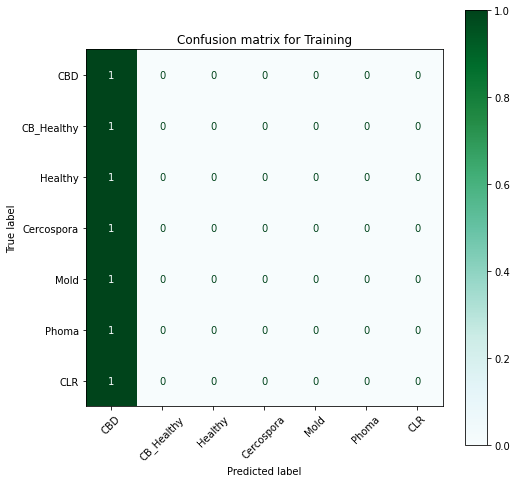

In [57]:
fig,ax = plt.subplots(figsize=(8,8)) 
cm = confusion_matrix(y_tr_r, round_pred_tr,normalize='true')
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=labeles)
disp.plot(cmap='BuGn',ax = ax,xticks_rotation=45)
disp.ax_.set_title("Confusion matrix for Training")
plt.show()

In [ ]:
print(classification_report(y_tr_r,round_pred_tr))

              precision    recall  f1-score   support

           0       1.00      0.99      0.99       777
           1       0.99      1.00      0.99       666
           2       1.00      1.00      1.00       857
           3       1.00      1.00      1.00       647
           4       1.00      1.00      1.00       654
           5       1.00      1.00      1.00       649
           6       1.00      1.00      1.00       694

    accuracy                           1.00      4944
   macro avg       1.00      1.00      1.00      4944
weighted avg       1.00      1.00      1.00      4944



/usr/local/lib/python3.7/dist-packages/pretty_confusion_matrix/pretty_confusion_matrix.py:200: MatplotlibDeprecationWarning: 
The tick1On function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use Tick.tick1line.set_visible instead.
  t.tick1On = False
/usr/local/lib/python3.7/dist-packages/pretty_confusion_matrix/pretty_confusion_matrix.py:201: MatplotlibDeprecationWarning: 
The tick2On function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use Tick.tick2line.set_visible instead.
  t.tick2On = False
/usr/local/lib/python3.7/dist-packages/pretty_confusion_matrix/pretty_confusion_matrix.py:203: MatplotlibDeprecationWarning: 
The tick1On function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use Tick.tick1line.set_visible instead.
  t.tick1On = False
/usr/local/lib/python3.7/dist-packages/pretty_confusion_matrix/pretty_confusion_matrix.py:204: MatplotlibDeprecationWarning: 
The tick2On function was deprecated in Matplotlib 3.1 and will be remo

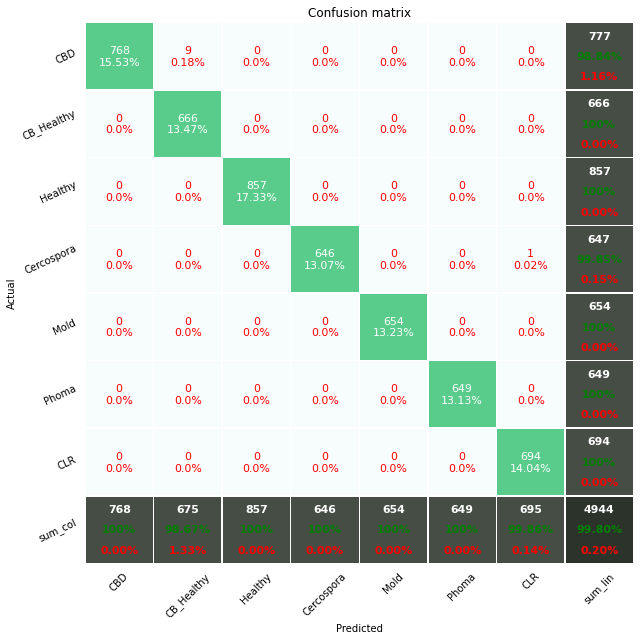

In [ ]:
pp_matrix_from_data(y_tr_r, round_pred_tr,cmap='BuGn',columns=labeles,figsize=[7,7],pred_val_axis='x')

### validation confusion matrix

In [ ]:
pred_v = e_model.predict([x_v,x_v])
round_pred_v = np.argmax(pred_v,axis=-1)
y_v_r = np.argmax(y_v,axis=-1)

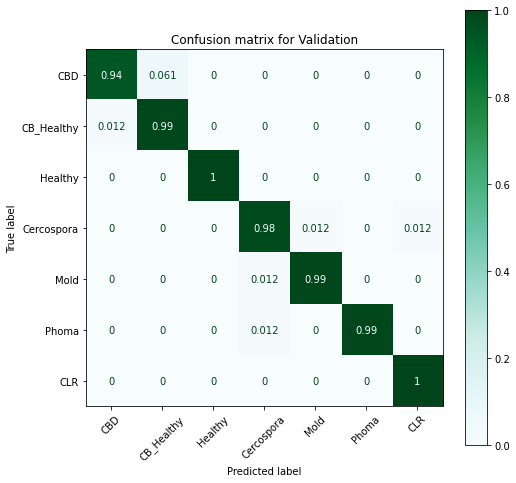

              precision    recall  f1-score   support

           0       0.99      0.94      0.96        98
           1       0.93      0.99      0.96        83
           2       1.00      1.00      1.00       107
           3       0.98      0.98      0.98        81
           4       0.99      0.99      0.99        82
           5       1.00      0.99      0.99        81
           6       0.99      1.00      0.99        86

    accuracy                           0.98       618
   macro avg       0.98      0.98      0.98       618
weighted avg       0.98      0.98      0.98       618



In [ ]:
fig,ax = plt.subplots(figsize=(8,8)) 
cm = confusion_matrix(y_v_r, round_pred_v,normalize='true')
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=labeles)
disp.plot(cmap='BuGn',ax = ax,xticks_rotation=45)
disp.ax_.set_title("Confusion matrix for Validation")
plt.show()
print(classification_report(y_v_r,round_pred_v))

/usr/local/lib/python3.7/dist-packages/pretty_confusion_matrix/pretty_confusion_matrix.py:200: MatplotlibDeprecationWarning: 
The tick1On function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use Tick.tick1line.set_visible instead.
  t.tick1On = False
/usr/local/lib/python3.7/dist-packages/pretty_confusion_matrix/pretty_confusion_matrix.py:201: MatplotlibDeprecationWarning: 
The tick2On function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use Tick.tick2line.set_visible instead.
  t.tick2On = False
/usr/local/lib/python3.7/dist-packages/pretty_confusion_matrix/pretty_confusion_matrix.py:203: MatplotlibDeprecationWarning: 
The tick1On function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use Tick.tick1line.set_visible instead.
  t.tick1On = False
/usr/local/lib/python3.7/dist-packages/pretty_confusion_matrix/pretty_confusion_matrix.py:204: MatplotlibDeprecationWarning: 
The tick2On function was deprecated in Matplotlib 3.1 and will be remo

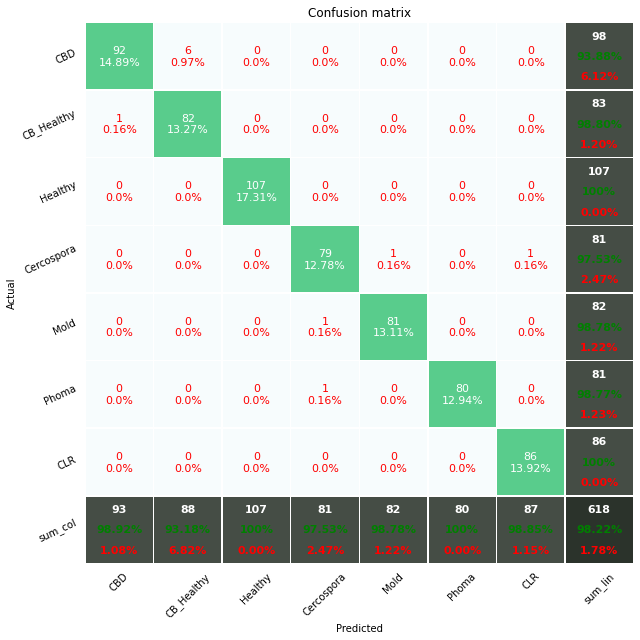

In [ ]:
pp_matrix_from_data(y_v_r, round_pred_v,cmap='BuGn',columns=labeles,figsize=[7,7],pred_val_axis='x')

### confusion matrix Testing

In [ ]:
pred_t = e_model.predict([x_tes,x_tes])
round_pred_t = np.argmax(pred_t,axis=-1)
y_tes_r = np.argmax(y_tes,axis=-1)

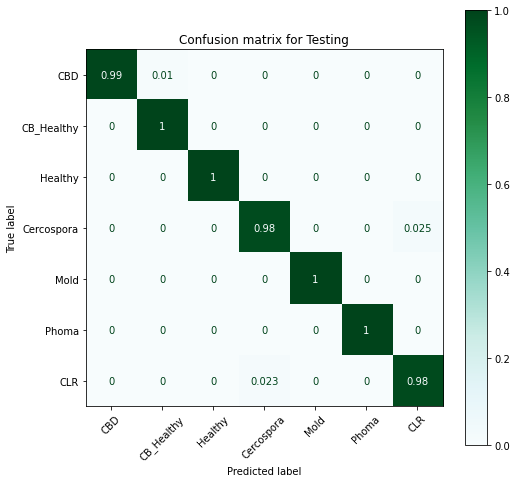

              precision    recall  f1-score   support

           0       1.00      0.99      0.99        97
           1       0.99      1.00      0.99        83
           2       1.00      1.00      1.00       107
           3       0.98      0.98      0.98        81
           4       1.00      1.00      1.00        82
           5       1.00      1.00      1.00        81
           6       0.98      0.98      0.98        87

    accuracy                           0.99       618
   macro avg       0.99      0.99      0.99       618
weighted avg       0.99      0.99      0.99       618



In [ ]:
fig,ax = plt.subplots(figsize=(8,8)) 
cm = confusion_matrix(y_tes_r, round_pred_t,normalize='true')
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=labeles)
disp.plot(cmap='BuGn',ax = ax,xticks_rotation=45)
disp.ax_.set_title("Confusion matrix for Testing")
plt.show()
print(classification_report(y_tes_r,round_pred_t))

/usr/local/lib/python3.7/dist-packages/pretty_confusion_matrix/pretty_confusion_matrix.py:200: MatplotlibDeprecationWarning: 
The tick1On function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use Tick.tick1line.set_visible instead.
  t.tick1On = False
/usr/local/lib/python3.7/dist-packages/pretty_confusion_matrix/pretty_confusion_matrix.py:201: MatplotlibDeprecationWarning: 
The tick2On function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use Tick.tick2line.set_visible instead.
  t.tick2On = False
/usr/local/lib/python3.7/dist-packages/pretty_confusion_matrix/pretty_confusion_matrix.py:203: MatplotlibDeprecationWarning: 
The tick1On function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use Tick.tick1line.set_visible instead.
  t.tick1On = False
/usr/local/lib/python3.7/dist-packages/pretty_confusion_matrix/pretty_confusion_matrix.py:204: MatplotlibDeprecationWarning: 
The tick2On function was deprecated in Matplotlib 3.1 and will be remo

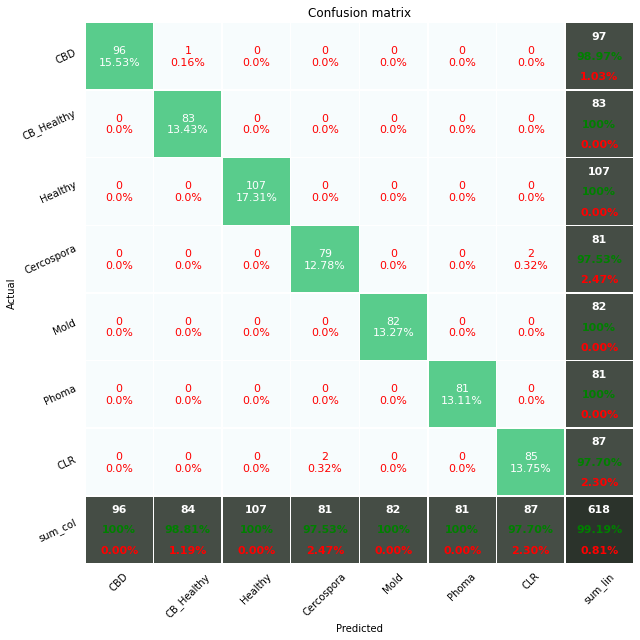

In [ ]:
pp_matrix_from_data(y_tes_r, round_pred_t,cmap='BuGn',columns=labeles,figsize=[7,7],pred_val_axis='x')